# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [2]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

In [2]:
import intake

ModuleNotFoundError: No module named 'intake'

## Load the trends of the observations

In [9]:
%%time

os.chdir(wrkdir + "/data/")
imfs_sst_ds = xr.open_dataset("imfs_sst_CEEMDAN.nc")
imfs_mld_ds = xr.open_dataset("imfs_mld_CEEMDAN.nc")
imfs_z20_ds = xr.open_dataset("imfs_z20_CEEMDAN.nc")
imfs_oxy_ds = xr.open_dataset("imfs_oxy_CEEMDAN.nc")
imfs_chl_ds = xr.open_dataset("imfs_chl_CEEMDAN.nc")

sst_trend = imfs_sst_ds['sst_trend']
mld_trend = imfs_mld_ds['mld_trend']
z20_trend = imfs_z20_ds['z20_trend']
oxy_trend = imfs_oxy_ds['oxy_trend']
chl_trend = imfs_chl_ds['chl_trend']

sst_anom = imfs_sst_ds['sst_anom']
mld_anom = imfs_mld_ds['mld_anom']
z20_anom = imfs_z20_ds['z20_anom']
oxy_anom = imfs_oxy_ds['oxy_anom']
chl_anom = imfs_chl_ds['chl_anom']

sst_var = imfs_sst_ds['sst_imfs'].sum(dim='IMF').std(dim='time')
z20_var = imfs_z20_ds['z20_imfs'].sum(dim='IMF').std(dim='time')
chl_var = imfs_chl_ds['chl_imfs'].sum(dim='IMF').std(dim='time')


CPU times: user 5.89 s, sys: 14 s, total: 19.9 s
Wall time: 38.2 s


## Load the SST, MLD, O2 at 200m, and Chl data

In [4]:
%%time

sst = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_sst_2005-2024.nc")['sst']
mld = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_mld_2005-2024.nc")['mld']
z20 = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_z20_2005-2024.nc")['z20']
oxy = xr.open_dataset("/g/data/es60/pjb581/SPC/data/GOBAIv2.2_oxy200m_2004-2023.nc")['oxy200m']
#oxycline = xr.open_dataset("/g/data/es60/pjb581/SPC/data/GOBAIv2.2_oxycline_2004-2023.nc")['oxycline']
#pO2_m_p50_z200 = xr.open_dataset("/g/data/es60/pjb581/SPC/data/GOBAIv2.2_pO2_m_p50_SJ_z200_2004-2023.nc")['pO2_m_p50_z200']
#p50_critz = xr.open_dataset("/g/data/es60/pjb581/SPC/data/GOBAIv2.2_p50_critz_SJ_2004-2023.nc")['p50_critz']
chl = xr.open_dataset("/g/data/es60/pjb581/SPC/data/OCNET_chla_2001-2023.nc")['chlorophyll-a']
#p50_kPa.to_netcdf(wrkdir + "/Skipjack_O2_p50.nc")

chl = chl.rename({"latitude":"lat", "longitude":"lon"})


CPU times: user 65 ms, sys: 51.8 ms, total: 117 ms
Wall time: 490 ms


## extract the timeseries of these datasets at some example Pacific Island States/Nations

In [5]:
%%time

# Define the approximate latitude and longitude for each location
locations = {
    "Hawaii": [(19.0, -156.0+360.0)],
    "Kiribati": [(3.1, -171.5+360.0)],  # Multiple island groups
    "Nauru": [(-0.5, 166.9)],
    "Solomon Islands": [(-9.6, 161.0)],
    "Guam": [(13.4, 144.7)],
    "Tonga": [(-19.8, -174.8+360.0)]
}

# Extract the data
def extract_timeseries(dataar, locations):
    """Extracts time series from a dataset given location coordinates."""
    data = {}
    
    for name, coords in locations.items():
        lat, lon = coords[0]
        
        # Find the closest grid point in the dataset
        ds_sel = dataar.sel(lat=lat, lon=lon, method="nearest")
        
        # Extract time series
        time_series = ds_sel.to_dataframe()
        
        data[name] = time_series
        
    return data

# Extract time series
sst_timeseries = extract_timeseries(sst, locations)
z20_timeseries = extract_timeseries(z20, locations)
mld_timeseries = extract_timeseries(mld, locations)
oxy_timeseries = extract_timeseries(oxy, locations)
#oxycline_timeseries = extract_timeseries(oxycline, locations)
#pO2_m_p50_z200_timeseries = extract_timeseries(pO2_m_p50_z200, locations)
#p50_critz_timeseries = extract_timeseries(p50_critz, locations)
chl_timeseries = extract_timeseries(chl, locations)

# Extract anomaly time series
sst_anom_timeseries = extract_timeseries(sst_anom, locations)
z20_anom_timeseries = extract_timeseries(z20_anom, locations)
mld_anom_timeseries = extract_timeseries(mld_anom, locations)
oxy_anom_timeseries = extract_timeseries(oxy_anom, locations)
#oxycline_anom_timeseries = extract_timeseries(oxycline_anom, locations)
#pO2_m_p50_z200_anom_timeseries = extract_timeseries(pO2_m_p50_z200_anom, locations)
#p50_critz_anom_timeseries = extract_timeseries(p50_critz_anom, locations)
chl_anom_timeseries = extract_timeseries(chl_anom, locations)


CPU times: user 853 ms, sys: 3.47 s, total: 4.32 s
Wall time: 3min 45s


## Visualise the trends

CPU times: user 43.8 s, sys: 71.8 ms, total: 43.9 s
Wall time: 43.9 s


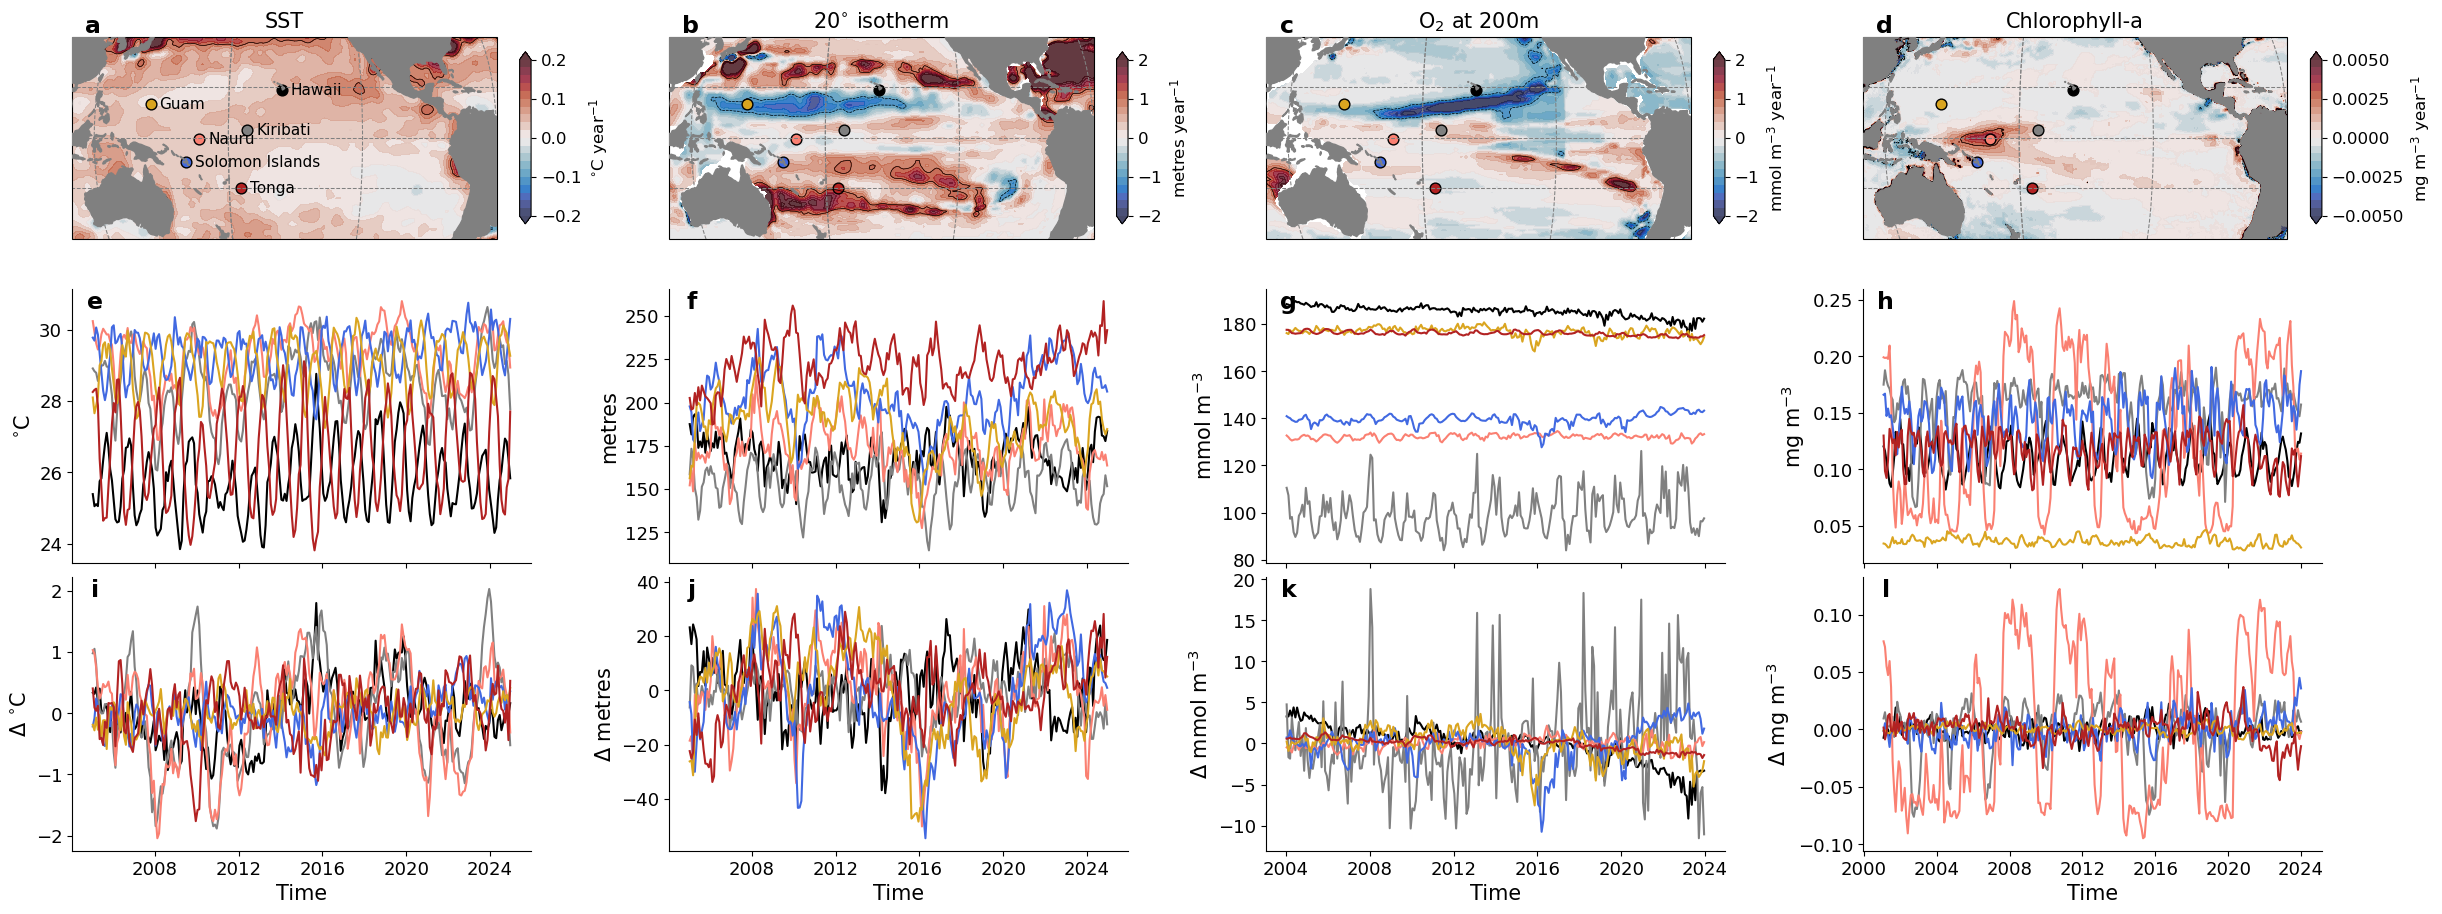

In [17]:
%%time

fstic = 13
fslab = 15

lon_sst = imfs_sst_ds.coords['lon'].values
lat_sst = imfs_sst_ds.coords['lat'].values
time_sst = imfs_sst_ds.coords['time'].values
lon_oxy = imfs_oxy_ds.coords['lon'].values
lat_oxy = imfs_oxy_ds.coords['lat'].values
time_oxy = imfs_oxy_ds.coords['time'].values
lon_chl = imfs_chl_ds.coords['lon'].values
lat_chl = imfs_chl_ds.coords['lat'].values
time_chl = imfs_chl_ds.coords['time'].values

### SST change
levs1 = np.arange(-10,11,1)*0.02
contlevs1 = [-0.1, 0.1]

### z20 change
levs2 = np.arange(-10,11,1)*0.2
contlevs2 = [-1, 1]

#### P50 at 200 metres
#levs3 = np.arange(-10,11,1)*0.02
#contlevs3 = [-0.01, 0.01]
levs3 = np.arange(-10,11,1)*0.2
contlevs3 = [-1.0, 1.0]

### Chl change per unit mode
levs4 = np.arange(-10,11,1)*0.0005
contlevs4 = [-0.0025, 0.0025]

proj = ccrs.Robinson(central_longitude=205)
colmap = lighten(cmo.balance, 0.8)

fig = plt.figure(figsize=(25,10))
gs = GridSpec(3,4)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[0,3], projection=proj)
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0])
ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2])
ax12 = plt.subplot(gs[2,3])

p1 = ax1.contourf(lon_sst, lat_sst, sst_trend*0.1, cmap=colmap, levels=levs1, extend='both', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, sst_trend*0.1, colors='k', linewidths=0.5, levels=contlevs1, transform=ccrs.PlateCarree())
p2 = ax2.contourf(lon_sst, lat_sst, z20_trend*0.1, cmap=colmap, levels=levs2, extend='both', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, z20_trend*0.1, colors='k', linewidths=0.5, levels=contlevs2, transform=ccrs.PlateCarree())
#p3 = ax3.contourf(lon_oxy, lat_oxy, pO2_m_p50_z200_trend*0.1, cmap=colmap, levels=levs3, extend='both', transform=ccrs.PlateCarree())
#ax3.contour(lon_oxy, lat_oxy, pO2_m_p50_z200_trend*0.1, colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())
p3 = ax3.contourf(lon_oxy, lat_oxy, oxy_trend*0.1, cmap=colmap, levels=levs3, extend='both', transform=ccrs.PlateCarree())
ax3.contour(lon_oxy, lat_oxy, oxy_trend*0.1, colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())
p4 = ax4.contourf(lon_chl, lat_chl, chl_trend*0.1, cmap=colmap, levels=levs4, extend='both', transform=ccrs.PlateCarree())
ax4.contour(lon_chl, lat_chl, chl_trend*0.1, colors='k', linewidths=0.5, levels=contlevs4, transform=ccrs.PlateCarree())

cols = ['k', 'grey', 'salmon', 'royalblue', 'goldenrod', 'firebrick']
ii = 0
# Add location points to the map
for name, coords in locations.items():
    lat, lon = coords[0]
    ax1.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    ax1.text(lon + 4, lat, name, fontsize=fstic-2, transform=ccrs.PlateCarree(), ha='left', va='center')
    ax2.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    #ax2.text(lon + 3, lat, name, fontsize=9, transform=ccrs.PlateCarree(), ha='left', va='center')
    ax3.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    #ax3.text(lon + 3, lat, name, fontsize=9, transform=ccrs.PlateCarree(), ha='left', va='center')
    ax4.scatter(lon, lat, marker='o', s=60, color=cols[ii], edgecolors='k', transform=ccrs.PlateCarree())
    #ax4.text(lon + 3, lat, name, fontsize=9, transform=ccrs.PlateCarree(), ha='left', va='center')
    ii += 1

# plot the timeseries
ii = 0
for name, coords in locations.items():
    ax5.plot(time_sst, sst_timeseries[name]['sst']-273.15, color=cols[ii], label=name)
    ax6.plot(time_sst, z20_timeseries[name]['z20'], color=cols[ii], label=name)
    #ax7.plot(time_oxy, pO2_m_p50_z200_timeseries[name]['pO2_m_p50_z200'], color=cols[ii], label=name)
    ax7.plot(time_oxy, oxy_timeseries[name]['oxy200m'], color=cols[ii], label=name)
    ax8.plot(time_chl, chl_timeseries[name]['chlorophyll-a'], color=cols[ii], label=name)
    ii += 1

# plot the timeseries
ii = 0
for name, coords in locations.items():
    ax9.plot(time_sst, sst_anom_timeseries[name]['sst_anom'], color=cols[ii], label=name)
    ax10.plot(time_sst, z20_anom_timeseries[name]['z20_anom'], color=cols[ii], label=name)
    #ax11.plot(time_oxy, pO2_m_p50_z200_anom_timeseries[name]['pO2_m_p50_z200_anom'], color=cols[ii], label=name)
    ax11.plot(time_oxy, oxy_anom_timeseries[name]['oxy_anom'], color=cols[ii], label=name)
    ax12.plot(time_chl, chl_anom_timeseries[name]['chl_anom'], color=cols[ii], label=name)
    ii += 1

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)

lcol = 'grey'; lwid = 0.75; lsty = '--'
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)

ax1.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())
ax2.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())
ax3.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())
ax4.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())

plt.text(0.5,1.075, "SST", va='center', ha='center', transform=ax1.transAxes, fontsize=fslab)
plt.text(0.5,1.075, "20$^{\circ}$ isotherm", va='center', ha='center', transform=ax2.transAxes, fontsize=fslab)
plt.text(0.5,1.075, "O$_2$ at 200m", va='center', ha='center', transform=ax3.transAxes, fontsize=fslab)
plt.text(0.5,1.075, "Chlorophyll-a", va='center', ha='center', transform=ax4.transAxes, fontsize=fslab)

cbar1 = plt.colorbar(p1, ax=ax1, orientation='vertical', ticks=levs1[::5], fraction=0.025, aspect=15)
cbar2 = plt.colorbar(p2, ax=ax2, orientation='vertical', ticks=levs2[::5], fraction=0.025, aspect=15)
cbar3 = plt.colorbar(p3, ax=ax3, orientation='vertical', ticks=levs3[::5], fraction=0.025, aspect=15)
cbar4 = plt.colorbar(p4, ax=ax4, orientation='vertical', ticks=levs4[::5], fraction=0.025, aspect=15)

cbar1.ax.set_ylabel("$^{\circ}$C year$^{-1}$", fontsize=fslab-3)
cbar2.ax.set_ylabel("metres year$^{-1}$", fontsize=fslab-3)
cbar3.ax.set_ylabel("mmol m$^{-3}$ year$^{-1}$", fontsize=fslab-3)
cbar4.ax.set_ylabel("mg m$^{-3}$ year$^{-1}$", fontsize=fslab-3)

cbar1.ax.tick_params(labelsize=fstic-1)
cbar2.ax.tick_params(labelsize=fstic-1)
cbar3.ax.tick_params(labelsize=fstic-1)
cbar4.ax.tick_params(labelsize=fstic-1)


ax5.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax6.set_ylabel("metres", fontsize=fslab)
ax7.set_ylabel("mmol m$^{-3}$", fontsize=fslab)
ax8.set_ylabel("mg m$^{-3}$", fontsize=fslab)

ax9.set_ylabel("$\Delta$ $^{\circ}$C", fontsize=fslab)
ax10.set_ylabel("$\Delta$ metres", fontsize=fslab)
ax11.set_ylabel("$\Delta$ mmol m$^{-3}$", fontsize=fslab)
ax12.set_ylabel("$\Delta$ mg m$^{-3}$", fontsize=fslab)
ax9.set_xlabel("Time", fontsize=fslab)
ax10.set_xlabel("Time", fontsize=fslab)
ax11.set_xlabel("Time", fontsize=fslab)
ax12.set_xlabel("Time", fontsize=fslab)


ax5.tick_params(labelsize=fstic, labelbottom=False)
ax6.tick_params(labelsize=fstic, labelbottom=False)
ax7.tick_params(labelsize=fstic, labelbottom=False)
ax8.tick_params(labelsize=fstic, labelbottom=False)
ax9.tick_params(labelsize=fstic)
ax10.tick_params(labelsize=fstic)
ax11.tick_params(labelsize=fstic)
ax12.tick_params(labelsize=fstic)

plt.subplots_adjust(bottom=0.075, top=0.925, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

xx = 0.05; yy=1.05
plt.text(xx,yy, "a", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, "b", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, "c", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, "d", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy-0.1, "e", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy-0.1, "f", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy-0.1, "g", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy-0.1, "h", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy-0.1, "i", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax9.transAxes)
plt.text(xx,yy-0.1, "j", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax10.transAxes)
plt.text(xx,yy-0.1, "k", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax11.transAxes)
plt.text(xx,yy-0.1, "l", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax12.transAxes)

ax5.spines[['top','right']].set_visible(False)
ax6.spines[['top','right']].set_visible(False)
ax7.spines[['top','right']].set_visible(False)
ax8.spines[['top','right']].set_visible(False)
ax9.spines[['top','right']].set_visible(False)
ax10.spines[['top','right']].set_visible(False)
ax11.spines[['top','right']].set_visible(False)
ax12.spines[['top','right']].set_visible(False)


In [18]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_trends.png", dpi=300)
fig.savefig("./figures/obs_trends_transparent.png", dpi=300, transparent=True)


In [21]:
os.getcwd()

'/g/data/es60/pjb581/SPC'

CPU times: user 43.8 s, sys: 122 ms, total: 43.9 s
Wall time: 43.9 s


Text(0.025, 1.05, 'c')

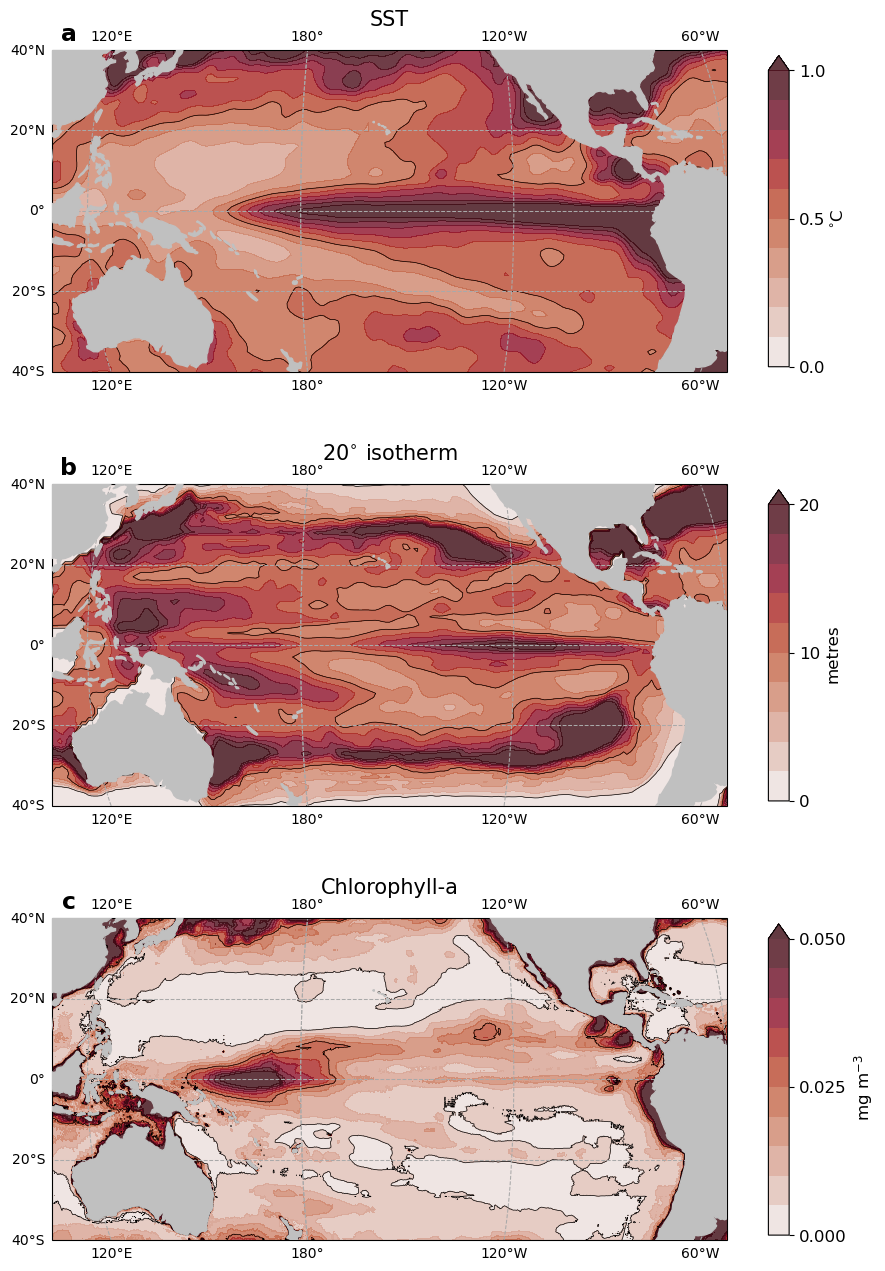

In [21]:
%%time

fstic = 13
fslab = 15

lon_sst = imfs_sst_ds.coords['lon'].values
lat_sst = imfs_sst_ds.coords['lat'].values
time_sst = imfs_sst_ds.coords['time'].values
lon_oxy = imfs_oxy_ds.coords['lon'].values
lat_oxy = imfs_oxy_ds.coords['lat'].values
time_oxy = imfs_oxy_ds.coords['time'].values
lon_chl = imfs_chl_ds.coords['lon'].values
lat_chl = imfs_chl_ds.coords['lat'].values
time_chl = imfs_chl_ds.coords['time'].values

### SST change
levs1 = np.arange(0,11,1)*0.1
contlevs1 = [0.1, 0.5]

### z20 change
levs2 = np.arange(0,11,1)*2
contlevs2 = [2, 10]

### Chl change per unit mode
levs3 = np.arange(0,11,1)*0.005
contlevs3 = [0.005, 0.025]

proj = ccrs.Robinson(central_longitude=205)
colmap = lighten(cmo.amp, 0.8)

fig = plt.figure(figsize=(10,14))
gs = GridSpec(3,1)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)
ax3 = plt.subplot(gs[2,0], projection=proj)

p1 = ax1.contourf(lon_sst, lat_sst, sst_var, cmap=colmap, levels=levs1, extend='max', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, sst_var, colors='k', linewidths=0.5, levels=contlevs1, transform=ccrs.PlateCarree())
p2 = ax2.contourf(lon_sst, lat_sst, z20_var, cmap=colmap, levels=levs2, extend='max', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, z20_var, colors='k', linewidths=0.5, levels=contlevs2, transform=ccrs.PlateCarree())
p3 = ax3.contourf(lon_chl, lat_chl, chl_var, cmap=colmap, levels=levs3, extend='max', transform=ccrs.PlateCarree())
ax3.contour(lon_chl, lat_chl, chl_var, colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, color='silver', zorder=3)
ax2.add_feature(cfeature.LAND, color='silver', zorder=3)
ax3.add_feature(cfeature.LAND, color='silver', zorder=3)

lcol = 'darkgrey'; lwid = 0.75; lsty = '--'
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle=lsty, color=lcol, linewidth=lwid)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle=lsty, color=lcol, linewidth=lwid)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle=lsty, color=lcol, linewidth=lwid)

ax1.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())
ax2.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())
ax3.set_extent([110, 300, -40, 40], crs=ccrs.PlateCarree())

plt.text(0.5,1.095, "SST", va='center', ha='center', transform=ax1.transAxes, fontsize=fslab)
plt.text(0.5,1.095, "20$^{\circ}$ isotherm", va='center', ha='center', transform=ax2.transAxes, fontsize=fslab)
plt.text(0.5,1.095, "Chlorophyll-a", va='center', ha='center', transform=ax3.transAxes, fontsize=fslab)

cbar1 = plt.colorbar(p1, ax=ax1, orientation='vertical', ticks=levs1[::5], fraction=0.025, aspect=15)
cbar2 = plt.colorbar(p2, ax=ax2, orientation='vertical', ticks=levs2[::5], fraction=0.025, aspect=15)
cbar3 = plt.colorbar(p3, ax=ax3, orientation='vertical', ticks=levs3[::5], fraction=0.025, aspect=15)

cbar1.ax.set_ylabel("$^{\circ}$C", fontsize=fslab-3)
cbar2.ax.set_ylabel("metres", fontsize=fslab-3)
cbar3.ax.set_ylabel("mg m$^{-3}$", fontsize=fslab-3)

cbar1.ax.tick_params(labelsize=fstic-1)
cbar2.ax.tick_params(labelsize=fstic-1)
cbar3.ax.tick_params(labelsize=fstic-1)

plt.subplots_adjust(bottom=0.075, top=0.925, left=0.05, right=0.88, hspace=0.35, wspace=0.3)

xx = 0.025; yy=1.05
plt.text(xx,yy, "a", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, "b", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, "c", fontsize=fslab+2, fontweight="bold", ha='center', va='center', transform=ax3.transAxes)


In [22]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_variability.png", dpi=300)
fig.savefig("./figures/obs_variability_transparent.png", dpi=300, transparent=True)
